# Distribution
- Plot different dimensions
- PCA
- lastModifiedDateTime to something we can use

In [31]:
%load_ext autoreload
%autoreload 1
# All modules that are imported via %aimport are automatically updated if the sourcefile is changed.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
import random
import os
import itertools
%aimport Toolbox.tools
from Toolbox.tools import getKeysfromNames, writeNames, load_data, resample, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
# For the OSF:
%aimport Toolbox.OSF
from Toolbox.OSF import OSF
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
folderpath = '../data/test10/'
filename = 'order_fraud_ml_norm000000000000'

In [3]:
train_X, test_X, train_Y, test_Y = load_data(folderpath, split=0.05)

Load all files from folder and concatenate
Found 21 files
Data Splitted in Train and Test


In [4]:
#train_X.isnull().sum()
#np.unique(train_X.isnull().sum())
train_X.fillna(0, inplace=True)
test_X.fillna(0, inplace=True)

In [5]:
#Show the data split
trainsplit= (train_Y.value_counts())
testsplit= (test_Y.value_counts())
train_minor = trainsplit[1]/(trainsplit[1]+trainsplit[0])
test_minor = testsplit[1]/(testsplit[1]+testsplit[0])

print("TRAIN DATA \n{}\nminor class:{}%".format(trainsplit,round(100*train_minor,2)))
print("TEST DATA \n{}\nminor class:{}%".format(testsplit,round(100*test_minor,2)))

TRAIN DATA 
0    566637
1      5730
Name: 0, dtype: int64
minor class:1.0%
TEST DATA 
0    29848
1      277
Name: 0, dtype: int64
minor class:0.92%


In [6]:
# Bias sampling
train_X_sample, train_Y_sample = resample(train_X, train_Y, bias = 2)

Class 0: 11324 samples
Class 1: 5866 samples


# OSFs

In [ ]:
# Create smaller test set for now
#testy = test.iloc[:30000,:]
#testy.to_csv(folderpath+'test_'+filename+'.csv', header=None)

In [7]:
osfs = ['knn']
distances = [2] # Corresponding to l1 (Manhattan), l2(Euclidean), l3 etc. distance.
neighbors = [2,3] # Number of neighbors to take into account
weights = 'uniform' # random or uniform
perturbations = 1 # Makes only sense if weights = random for boosting different dimensions
osf = OSF(osfs, neighbors, weights, perturbations, distances)

In [ ]:
# Test Computational Complexitydown vote
import time

for i in [1000, 5000, 10000, 20000, 30000, 50000]:
    osf = OSF(osfs, neighbors, weights, perturbations, distances)
    start = time.time()
    osf.fit_transform(test_X[:i])
    end = time.time()
    print("i = {} time: {}".format(i, (end-start)))

In [8]:
train_X_trans = osf.fit_transform(train_X_sample)
train_X_trans.shape
test_X_trans = osf.fit_transform(test_X)
test_X_trans.shape

added 1 out of 2 osf-features
added 2 out of 2 osf-features
Transformed from shape (17190, 174) into shape (17190, 2) in OSF-space
added 1 out of 2 osf-features
added 2 out of 2 osf-features
Transformed from shape (30125, 174) into shape (30125, 2) in OSF-space


(30125, 2)

In [9]:
train_X_new = np.concatenate([train_X_sample, train_X_trans], axis=1)
test_X_new = np.concatenate([test_X, test_X_trans], axis=1)

In [10]:
# Feature Scaling ( bring everything on value between 0 and 1)
train_X_trans= (train_X_trans-np.min(train_X_trans,0)) \
            / (np.max(train_X_trans,0)- np.min(train_X_trans,0))

test_X_trans= (test_X_trans-np.min(test_X_trans,0)) \
            / (np.max(test_X_trans,0)- np.min(test_X_trans,0))

In [ ]:
# Add target as first column and for _new also original features
train_trans = np.concatenate([train_Y_sample.reshape([len(train_Y_sample),1]), train_X_trans], axis=1)
train_new = np.concatenate([train_Y_sample.reshape([len(train_Y_sample),1]), train_X_sample, train_X_trans], axis=1)

test_trans = np.concatenate([test_Y.reshape([len(test_Y),1]), test_X_trans], axis=1)
test_new = np.concatenate([test_Y.reshape([len(test_Y),1]), test_X, test_X_trans], axis=1)

# Now convert to dataframe (workaround so first column can be int)
df_trans = pd.DataFrame(train_trans)
df_trans[0] = df_trans[0].astype(int)

df_test_trans = pd.DataFrame(test_trans)
df_test_trans[0] = df_test_trans[0].astype(int)

df_new = pd.DataFrame(train_new)
df_new[0] = df_new[0].astype(int)

df_test_new = pd.DataFrame(test_new)
df_test_new[0] = df_test_new[0].astype(int)

In [ ]:
# Save as .csv file
df_trans.to_csv(folderpath+'trans_'+filename+'.csv', index=False, header=None)
df_test_trans.to_csv(folderpath+'test_trans_'+filename+'.csv', index=False, header=None)

df_new.to_csv(folderpath+'new_'+filename+'.csv', index=False, header=None)
df_test_new.to_csv(folderpath+'test_new_'+filename+'.csv', index=False, header=None)

In [ ]:
# create a fake .names file, so the pipeline works
writeNames(df_trans.shape,folderpath+'trans_'+filename+'.names')
writeNames(df_new.shape,folderpath+'new_'+filename+'.names')

# Some Quick Performance Testing

Confusion matrix, without normalization
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     29848
          1       0.11      0.72      0.19       277

avg / total       0.99      0.94      0.96     30125



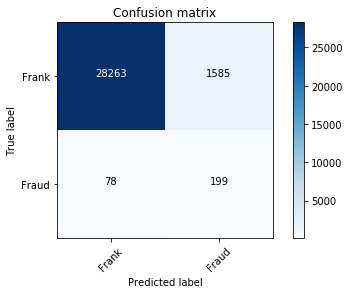

In [39]:
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2)
rf.fit(train_X_sample, train_Y_sample)
Y_pred = rf.predict(test_X)
cnf = confusion_matrix(test_Y, Y_pred)
plot_confusion_matrix(cnf, classes=['Frank', 'Fraud'])
print(classification_report(test_Y, Y_pred))

Confusion matrix, without normalization
             precision    recall  f1-score   support

          0       0.99      0.27      0.42     29848
          1       0.01      0.82      0.02       277

avg / total       0.98      0.27      0.41     30125



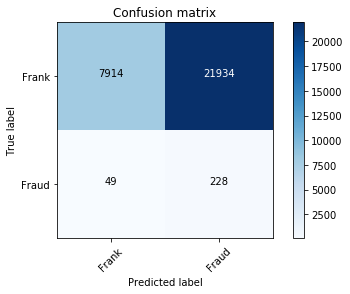

In [35]:
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2)
rf.fit(train_X_trans, train_Y_sample)
Y_pred = rf.predict(test_X_trans)
cnf = confusion_matrix(test_Y, Y_pred)
plot_confusion_matrix(cnf, classes=['Frank', 'Fraud'])
print(classification_report(test_Y, Y_pred))

Confusion matrix, without normalization
             precision    recall  f1-score   support

          0       1.00      0.94      0.97     29848
          1       0.11      0.73      0.19       277

avg / total       0.99      0.94      0.96     30125



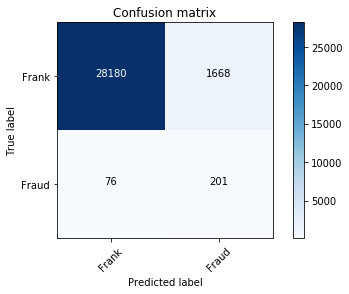

In [38]:
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2)
rf.fit(train_X_new, train_Y_sample)
Y_pred = rf.predict(test_X_new)
cnf = confusion_matrix(test_Y, Y_pred)
plot_confusion_matrix(cnf, classes=['Frank', 'Fraud'])
print(classification_report(test_Y, Y_pred))